# Optimization & Regularization Simulation

**Stability, convergence, and generalization for the MLP propensity model**
- Reuses the Northstar Outfitters scenario
- Uses **synthetic data** with the same schema so it runs anywhere
- Keeps charts to **matplotlib only**, one chart per cell, no explicit colors

In [1]:
import random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, warnings
from sklearn.model_selection import train_test_split
np.random.seed(42)
random.seed(42)

warnings.filterwarnings("ignore")


## Load or rebuild the synthetic dataset

In [2]:

# Reuse generation from Module 1 (copied here for standalone use)
n = 25000
device = np.random.choice(["mobile","desktop"], size=n, p=[0.6,0.4])
country = np.random.choice(["US","CA","UK","DE"], size=n, p=[0.6,0.15,0.15,0.10])
sessions = np.random.poisson(2.3, size=n)
pages = np.maximum(1, (np.random.normal(5 + (device=="desktop")*1.1, 2.1, size=n)).astype(int))
dwell = np.maximum(10, np.random.normal(120 + 15*(pages>6), 45, size=n)).astype(int)
adds = np.random.binomial(1, p=np.clip(0.05 + 0.02*(pages>6) + 0.03*(dwell>150), 0, 0.5), size=n)
promo_seen = np.random.binomial(1, 0.3, size=n)
z = -2.0 + 0.25*sessions + 0.12*pages + 0.004*dwell + 0.6*adds + 0.2*promo_seen + 0.3*(device=="mobile")
z += 0.2*(country=="US") - 0.05*(country=="DE") + np.random.normal(0,0.85,size=n)
p = 1/(1+np.exp(-z)); y = (np.random.rand(n) < p).astype(int)
df = pd.DataFrame({"device":device,"country":country,"sessions":sessions,"pages":pages,"dwell":dwell,"adds":adds,"promo_seen":promo_seen,"y":y})
X = pd.get_dummies(df.drop(columns=["y"]), drop_first=True); y = df["y"].values
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_tr.shape, X_val.shape


((20000, 9), (5000, 9))

## Compare regularization & early stopping

In [ ]:

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss

def run_cfg(hidden=(64,32), alpha=1e-4, early=True, seed=0):
    pipe = Pipeline([("sc", StandardScaler(with_mean=False)),
                     ("mlp", MLPClassifier(hidden_layer_sizes=hidden, activation="relu",
                                           alpha=alpha, batch_size=256, max_iter=40,
                                           early_stopping=early, random_state=seed))])
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_val)[:,1]
    return {"hidden":hidden,"alpha":alpha,"early":early,"seed":seed,
            "pr_auc":average_precision_score(y_val,p),
            "roc_auc":roc_auc_score(y_val,p),
            "brier":brier_score_loss(y_val,p)}

results = pd.DataFrame(run_cfg(alpha=a, early=e, seed=s) for a in [1e-5,1e-4,1e-3] for e in [True, False] for s in [0,1,2])

display(results)


,hidden,alpha,early,seed,pr_auc,roc_auc,brier
0,"(64, 32)",0.00001,True,0,0.628283,0.616456,0.239134
1,"(64, 32)",0.00001,True,1,0.625674,0.615220,0.239413
2,"(64, 32)",0.00001,True,2,0.623346,0.613405,0.240153
3,"(64, 32)",0.00001,False,0,0.624749,0.613096,0.240301
4,"(64, 32)",0.00001,False,1,0.625945,0.616590,0.239496
5,"(64, 32)",0.00001,False,2,0.624729,0.612718,0.240247
6,"(64, 32)",0.00010,True,0,0.626414,0.614428,0.239482
7,"(64, 32)",0.00010,True,1,0.627813,0.615427,0.239504
8,"(64, 32)",0.00010,True,2,0.630644,0.616757,0.238878
9,"(64, 32)",0.00010,False,0,0.624255,0.611498,0.240640


## Plot metric vs weight decay (alpha)

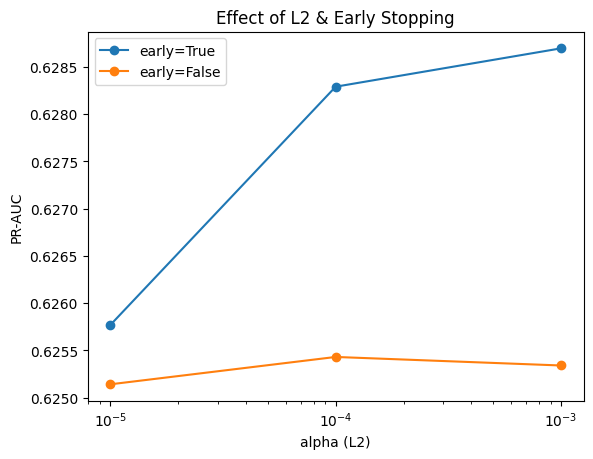

In [4]:

dfres = results
plt.figure()
for e in [True, False]:
    sub = dfres[dfres.early==e].groupby("alpha")["pr_auc"].mean().reset_index()
    plt.plot(sub["alpha"], sub["pr_auc"], marker="o", label=f"early={e}")
plt.xscale("log"); plt.xlabel("alpha (L2)"); plt.ylabel("PR-AUC"); plt.title("Effect of L2 & Early Stopping"); plt.legend()
plt.show()
